- Github repo: https://github.com/CesareGao/analysis_of_fountain_pen_purchase
- Team member: Yan Gao
- Contribution: All bellow, hahaha.

# Analysis of Fountain Pen Purchase

## Quesions and Motivation

### Quesion A
Does the text description really make sense to the price tag when we purchase a product? Could it show some guide to how luxury the products are in same type of them? For example, distinguish between different fountain pens. Looking at the product description is an usual way for us to select a product when there are several choices. This is sometimes hard to make a decision. But does the text description really make sense to the price? I want to verify this. 

- Input: the text description
- Output: the predicted price

### Quesion B
How to find the most important features related to the price of the product. When we are purchasing a product, we want to know which feature, and which its level contribute most to the price setting process. So that we can make choices to select a number of cost features and avoid the others according to our budget plan.

- Input: all the numeric and categorical features
- Output: selected features and its levels mainly contribute to the price

In [2]:
%matplotlib inline 
import numpy as np
import pandas as pd # for data analysis
import matplotlib.pyplot as plt # for plotting
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn.linear_model import LassoCV, LogisticRegressionCV, RidgeCV, LogisticRegression, Lasso,LinearRegression
from sklearn.metrics import classification_report, roc_curve, log_loss, auc
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from PIL import Image
import requests
from io import BytesIO
import seaborn as sns

## Dataset Discription

This is a dataset of more than 600 fountain pens, which I grapped in [Goulet Pens Company](https://www.gouletpens.com/collections/all-fountain-pens/products?page=1)

It has really rich amount of information for each fountain pen. The specs are quite precise and standard. It gets over 60 features. Some main features are introduced bellow:

- url: unique url for each fountain pen
- Price: our target variable
- Brand: which brand the pen belongs to
- Color: the main color of pen body
- Body_Material, Cap_Type, Compatible_inks_&_refills, Filling_Mechanism, Grip_Material ...: basic properties of pens
- Dimension: different dimension numeric variables
- description: raw discription for each pen
- feature_image: an image of the fountain pen

## Data Cleaning

Detailed cleaning code please check the cleaning_data.ipynb in repository

### Cleaning activity

- Convert all the numeric features(e.g. Price) from string to float and remove their units
- Convert date formated features(e.g. create_at) to datatime type
- Correct all typos and merge different names but same level of factor in the categorical data(e.g. Namiki and Namiki Royal)
- Merge columns with same spec(e.g. merge "Max_Ink_Capacity_Piston_Vac", "Max_Ink_Capacity_Cartridge", "Max_Ink_Capacity_Converter", "Max_Ink_Capacity_Eyedropper" to "Max_Ink_Capacity")
- build "clean_description" for text description data

### Handle missing value and non-informative data

- Fill NaN with domain knowledge(e.g. take numeric data in same brand series to fill other missing value)
- Drop rows with lots of missing data(more than 10 missing values
- drop columns with duplicate information
- drop non-informative columns(e.g. columns with only one level of factor)

### Data summary statistics and interpretation

This cleaned dataset has lots of numeric and categorical data. In Question A, I only used the Prics as response variable and clean_description as explanatory variable, so I don't care about other NaN values. But in Question B, this will be cleaned in data preparation for model.

In [3]:
pens_df = pd.read_csv("clean_fountain_pen_dataset.csv").drop(["Unnamed: 0"],axis=1)
pens_df.head()

,url,Product_Code,Name,In_Stock,Price,Nib_Size,Brand,Color,Demonstrator,Body_Material,...,Weight_Overall,Cap_Rotations,created_at,description,featured_image,images,published_at,clean_description,Series,Max_Ink_Capacity
0,https://www.gouletpens.com/collections/all-fou...,Plat-PSQ-400-01-1,Platinum Preppy Fountain Pen - Black,True,5.00,"Extra-Fine, Fine, Medium",Platinum,Black,Yes,Resin,...,13.0,NaN,2018-05-02 10:28:05-04:00,\nThe Platinum Preppy fountain pen is one of t...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,one best value money fantastic starter great l...,Preppy,4.33
1,https://www.gouletpens.com/collections/all-fou...,PN91111,Pilot Metropolitan Fountain Pen - Black Plain,True,23.99,"Fine, Medium, 1.0mm Stub",Pilot,Black,No,Lacquered metal,...,26.0,NaN,2018-05-02 10:28:13-04:00,"\nA fantastic value from Pilot, the Metropolit...",//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,fantastic value favorite first black metal bod...,Metropolitan,1.30
2,https://www.gouletpens.com/collections/all-fou...,TW-M7445300,TWSBI ECO Fountain Pen - Clear,True,28.99,"Extra-Fine, Fine, Medium, Broad, 1.1mm Stub",TWSBI,Clear,Yes,Resin,...,21.0,1.00,2018-05-02 10:28:24-04:00,\r\n The TW...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,boast incredible value piston filling system a...,ECO,1.76
3,https://www.gouletpens.com/collections/all-fou...,N15021,Noodler's Ahab Flex Fountain Pen - Clear,True,23.00,Flex,Noodler's,Clear,Yes,Resin,...,18.0,2.25,2018-05-02 10:25:05-04:00,\r\n The No...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,noodler 's ahab flex feature steel flexible 6 ...,Ahab Flex,6.17
4,https://www.gouletpens.com/collections/all-fou...,Plat-PSQ-400-03-1,Platinum Preppy Fountain Pen - Blue,True,4.98,"Extra-Fine, Fine, Medium",Platinum,Blue,Yes,Resin,...,13.0,NaN,2018-05-02 10:28:06-04:00,\nThe Platinum Preppy fountain pen is one of t...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,one best value money fantastic starter great l...,Preppy,4.33


In [5]:
print(pens_df.dtypes)
print(pens_df.isna().sum())

url                             object
Product_Code                    object
Name                            object
In_Stock                        object
Price                          float64
Nib_Size                        object
Brand                           object
Color                           object
Demonstrator                    object
Body_Material                   object
Cap_Type                        object
Compatible_inks_&_refills       object
Filling_Mechanism               object
Grip_Material                   object
Nib_Color                       object
Nib_Material                    object
Postable                        object
Retractable                     object
Trim                            object
Diameter_Body                  float64
Diameter_Cap_(without_clip)    float64
Diameter_Cap_(with_clip)       float64
Diameter_Grip                  float64
Length_Body                    float64
Length_Cap                     float64
Length_Nib               

## Visualization

### The relation of different numeric predictors

To check whether there is any relation between the price and other physical numeric predictors.

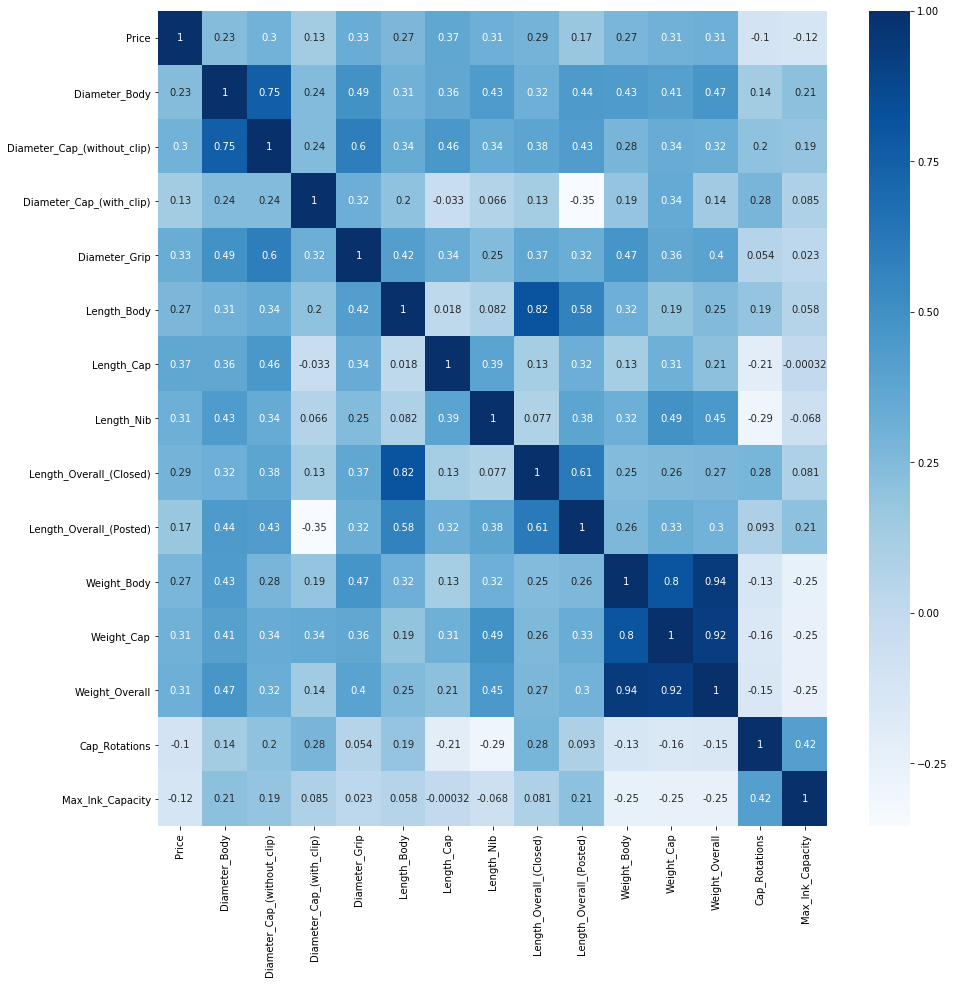

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(pens_df.corr(),annot=True,cmap=plt.cm.Blues)

There is no many strong correlation among price and other numeric predictors. So the physical parameters of the fountain pen may not strongly effect the price of the fountain pens.

Some numeric features like the weight of different parts are hight correlated. So maybe Lasso regression should be applied.

### The total distribution histgram of fountain pen price

To check if the plot looks approximately normal.

(array([530.,  54.,  18.,  18.,   4.,   6.,   3.,   4.,   0.,   3.,   1.,
          2.,   1.,   1.,   0.,   0.,   0.,   2.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([3.3000000e+00, 2.1323400e+02, 4.2316800e+02, 6.3310200e+02,
        8.4303600e+02, 1.0529700e+03, 1.2629040e+03, 1.4728380e+03,
        1.6827720e+03, 1.8927060e+03, 2.1026400e+03, 2.3125740e+03,
        2.5225080e+03, 2.7324420e+03, 2.9423760e+03, 3.1523100e+03,
        3.3622440e+03, 3.5721780e+03, 3.7821120e+03, 3.9920460e+03,
        4.2019800e+03, 4.4119140e+03, 4.6218480e+03, 4.8317820e+03,
        5.0417160e+03, 5.2516500e+03, 5.4615840e+03, 5.6715180e+03,
        5.8814520e+03, 6.0913860e+03, 6.3013200e+03, 6.5112540e+03,
        6.7211880e+03, 6.9311220e+03, 7.1410560e+03, 7.3509900e+03,
        7.5609240e+03, 7.7708580e+03, 7.980792

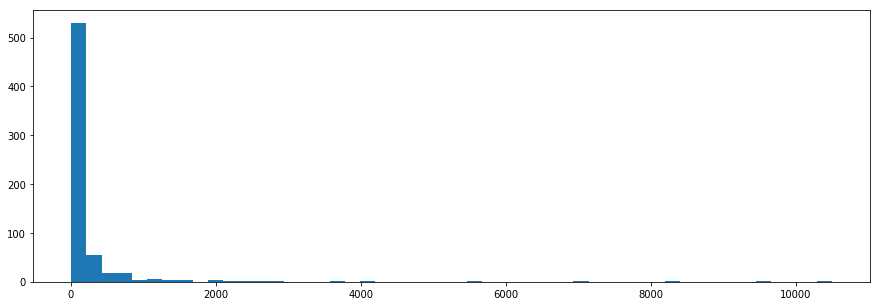

In [8]:
plt.figure(figsize=(15,5))
plt.hist(pens_df.Price,bins=2*int(np.sqrt(pens_df.shape[0])))

According to the plot, most fountain pen are no more than \$500, and the are some luxury pens too. By domain knowledge, the boundary between whether is a luxury pen or not is \\$200. So thankfully the data is not extremely unbalanced. There still great number of luxury pens. 

Some pens has extremely high price, which is reasonable. These should not be treated as outliers.

### The distribution boxplot of price with different brands and series

To check if there is any relation between brand and price

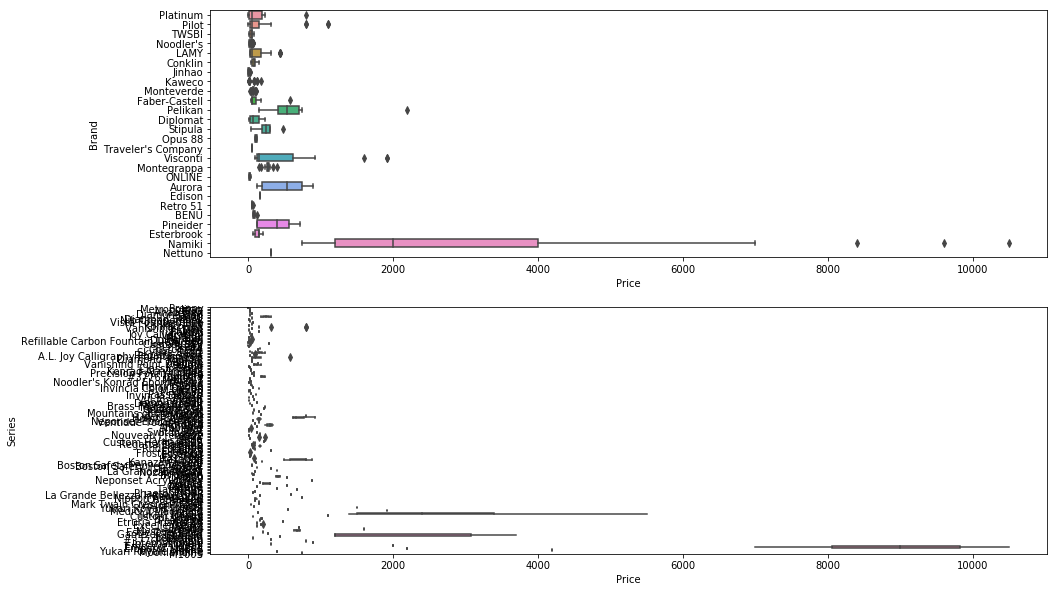

In [9]:
fig,axs = plt.subplots(2,1,figsize=(15,10))
sns.boxplot(x="Price", y="Brand", data=pens_df, orient="h",ax=axs[0])
sns.boxplot(x="Price", y="Series", data=pens_df, orient="h",ax=axs[1])

According to the plot, the price does relate with the brand. More precisely, it relates with the series. Some brand has relatively great variance of its price even in same series.

### Compare price among whether it's a demonstrator or not 

Some customers prefer demonstrators, so the price of the demonstrator tend to be a bit higher than those are not. There are too much brands(26) so we only look at top tens.

(0, 350)

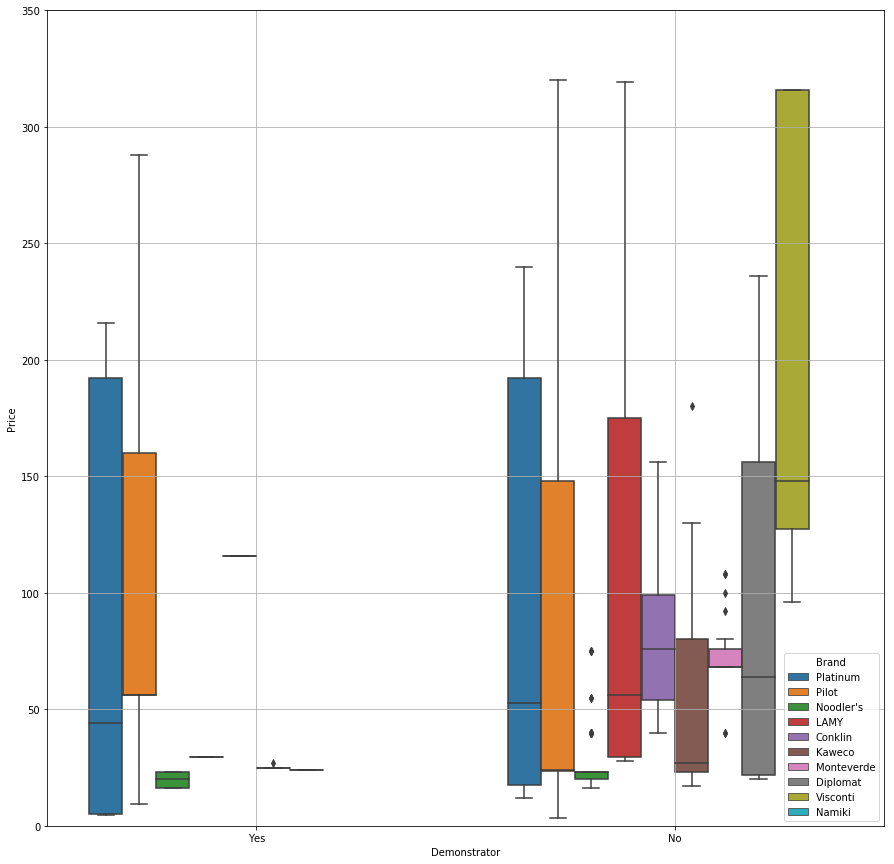

In [10]:
top_ten_brand = list(pens_df.Brand.value_counts()[:10].index)
sub_dat = pens_df[pens_df.Brand.apply(lambda x: x in top_ten_brand)]
plt.figure(figsize=(15,15))
sns.boxplot(x="Demonstrator", y="Price",hue="Brand", data=sub_dat)
plt.grid(True)
plt.ylim(0,350)

From the plot, the price of demonstrators are actually lower. So there should be some bias in the dataset. For example, not all the pens of same series or same brand are presented in this websit.

# Modelling 

The model A is build to try different choices in different step of building and training model. If you want to run this, please select only one choice among one step.

## *Model A*: use the text feature in predicting the price of the product

I want to explore whether the text message does show the pattern of setting price tag. Most of time when we plan to buy a product, we want to check the product discription to see if its really worth to buy. Does the product discription really tell us something important, distinguishable from other product? I doubt this as I always have trouble to buy a product and may hesitate to make the final decision. So I want to build a model to verify it.

In [3]:
model_A_df = pens_df[pens_df.clean_description.notnull()]
model_A_df[["Price","clean_description"]].sample(5)

,Price,clean_description
621,316.0,“ nineteen-eleven ” feature matte black resin ...
50,3.3,fashionable disposable 's convenient easy use ...
178,108.0,art technology blended perfect symbiosis resul...
94,60.0,diamond 580alr come benchmark piston ink-filli...
580,123.0,opus 88 large eyedropper-filled piston operate...


### *Response Variable Choice 1*: continuous variable

The price could explicitly give the intuition of how much the product worths.

In [16]:
y = model_A_df.Price

### *Response Variable Choice 2*: discrete variable

The price can be seperated as affordable and unaffordable sometimes, or more intutively with high and low price. That makes sense when we have limited budget.

With domain knowledge, pen lovers always treat the $200 as the boundary between affordable and unaffordable pens.

In [39]:
y = np.where(model_A_df.Price < 200, 1, 0)

In [12]:
y.mean()

0.8024502297090352

This response are quite unbalanced. So when splitting the data we should be careful.

### *Explanatory Variable Choice 1*: use the count of each word to build the feature vector

All the stopwords and the feature words for each individual pen have been removed. The count of each word could implicate the importance of the text. 

In [24]:
clean_text = model_A_df.clean_description
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(clean_text)

### *Explanatory Variable Choice 2*: use the tf-idf features of each word to build the feature vector

The importance of the words will increase while the frequency of words in each text increase. But the importance is also limited by the frequency of word in all the text together. This inverse document frequency method can avoid the penalty of same words occur in multiple texts.

In this dataset, this could effectively lower the occur of technical words of product and concentrate more on the unique discription of each product.

In [21]:
clean_text = model_A_df.clean_description
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(clean_text)

### *Explanatory Variable Choice 3*: use PCA to reduce the dimension of the frequency count feature vector

As the frequency count data feature could be highly correlated, we could use PCA to find the principle components and recompute the feature vector to get less correlated data. This is useful for further logistic regression analysis as the logitstic regression can't seperate the correlation of the different predictors as Lasso or Ridge.

In [41]:
clean_text = model_A_df.clean_description
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(clean_text)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X.toarray())
print(X.shape)
print(X_pca.shape)
X = X_pca

(653, 3449)
(653, 86)


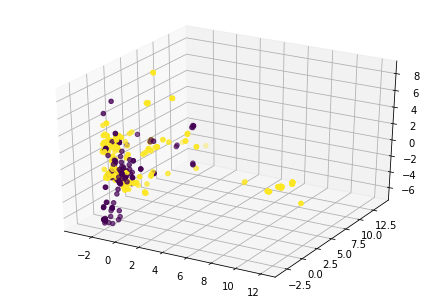

In [28]:
## Try projection with 3D PCA
clean_text = model_A_df.clean_description
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(clean_text)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:,0], X_pca[:,1],X_pca[:,2], c=y)

Both the 3D and 2D projection can not seperate the categorical response. Higher dimension is required.

### *Split the data*

To use train-validate-test validation could cost lots of data in the validate data and test data. The dataset is quite a small dataset. So it's more reasonable to use cross validation method to reuse the data many times to get more information and more precise result.

In [25]:
## numeric response 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
# val_X, test_X, val_y, test_y = train_test_split(test_X,test_y,test_size=0.5,random_state=1)
# train_X.shape, val_X.shape, test_X.shape

In [42]:
## categorical response for unbalanced class label
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,stratify=y)

### *Model Fitting Choice 1*: Ridge cross validation model

I ignored the exploration of the linear regression model, because its obvious that, in text data, there is some relation between the words. There should be some pattern such that some words always come after the certain other word. In the transformed feature vector of each text, this behaves as highly coefficients amount the different feature words predictors. So the variable of each predictor could very among different random states and also cause model overfitting.

So, for the continuous response, I choose the Ridge model to add penalty to the coefficient, suppress the co-linearity and get a better prediction.

In [26]:
ridge_reg = RidgeCV(cv=5,alphas=np.linspace(0.001,50,1000))
ridge_reg.fit(train_X,train_y)
ridge_reg.score(test_X,test_y)

/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9319972104157817

### *Model Fitting Choice 2*: Lasso cross validation model

Different from the Ridge regression, Lasso uses l2 penalty(sum of squares) rather than l1 penalty(absolute value). So Lasso could compute zero coefficient. This property gives it the function to do predictors selection and slove model overfitting.

To check for model overfitting and reduce its effect, the Lasso regression should be applied.

In [27]:
lasso_reg = LassoCV(cv=5,alphas=np.linspace(0.001,50,1000))
lasso_reg.fit(train_X,train_y)
lasso_reg.score(test_X,test_y)

/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/mnt/c/

0.8706798030636994

### *Model Fitting Choice 3*: Logistic regression cross validation model

If the response variable is a two-level categorical variable. Logistic regression is applied.

**Parameter setting**

- The C is set to be choosen from 1000 values between 1e-4 and 1e4 by grid search.
- The number of products is far smaller than the number of features, so the dual formulation should be implemented to avoid the lower explanatory functionality of each features. Under this condition, only the "liblinear" solver and ridge penalty could be choosen.

In [15]:
logistic_reg = LogisticRegressionCV(Cs=1000,cv=5,dual=True,penalty="l2",solver="liblinear",max_iter=1000)
logistic_reg.fit(train_X,train_y)
print(logistic_reg.score(test_X,test_y))
predict_y = logistic_reg.predict(test_X)
print(classification_report(test_y,predict_y,target_names=["low_price","high_price"]))

0.9770992366412213
              precision    recall  f1-score   support

   low_price       0.96      0.92      0.94        26
  high_price       0.98      0.99      0.99       105

   micro avg       0.98      0.98      0.98       131
   macro avg       0.97      0.96      0.96       131
weighted avg       0.98      0.98      0.98       131



### *Model Fitting Choice 4*: Logistic regression cross validation model with PCA components

Logistic regression can't handle the correlation between the different components. So using PCA to get principle component should get a better result.

**Parameter setting**

- The C is set to be choosen from 1000 values between 1e-4 and 1e4 by grid search.
- The number of products is greater enough than the number of features under PCA. So we do not need to use the dual choice.
- The Lasso regression is been implemented with the "saga" solver and "l1" penalty.

In [44]:
logistic_reg = LogisticRegressionCV(Cs = 1000,cv=5,max_iter=1000,penalty="l1",solver="saga")
logistic_reg.fit(train_X,train_y)
print(logistic_reg.score(test_X,test_y))
predict_y = logistic_reg.predict(test_X)
print(classification_report(test_y,predict_y,target_names=["low_price","high_price"]))

0.9770992366412213
              precision    recall  f1-score   support

   low_price       0.90      1.00      0.95        26
  high_price       1.00      0.97      0.99       105

   micro avg       0.98      0.98      0.98       131
   macro avg       0.95      0.99      0.97       131
weighted avg       0.98      0.98      0.98       131



### *Model selection* and *model application*

According to the fitting accuracy score, the finally selected models for different types of data are:

- Response Variable Choice 1 $\rightarrow$ Explanatory Variable Choice 1 $\rightarrow$ numeric response split $\rightarrow$ Model Fitting Choice 1. This model gets highest score of about 93%
- Response Variable Choice 2 $\rightarrow$ Explanatory Variable Choice 3 $\rightarrow$ categorical response split $\rightarrow$ Model Fitting Choice 4. This model gets highest score of 98%

Interestingly, in this dataset,choosing word frequency count as features is better than tf-idf features in continuous response model. And their performance get reverce in binary responce model. So whether to choose word frequency count or tf-idf should not be decided easily.

Bellow is a top play to show the prediction of two selected model

In [38]:
for _ in range(10):
    idx = np.random.randint(0,model_A_df.shape[0]-1)
    info = model_A_df.loc[idx][["Price","description","featured_image"]]
    # print(info[1])

    # response = requests.get("http:"+info[2])
    # img = Image.open(BytesIO(response.content))
    # plt.imshow(img)
    
    ## sample prediction of numeric response model
    pred_price = round(ridge_reg.predict(X[idx,])[0],1)

    print("The predicted price vs actual price: ${} vs {}".format(pred_price,info[0]))

the predicted price vs actual price: $37.1 vs 23.0
the predicted price vs actual price: $23.8 vs 52.0
the predicted price vs actual price: $34.4 vs 28.99
the predicted price vs actual price: $20.8 vs 16.1
the predicted price vs actual price: $13.3 vs 17.6
the predicted price vs actual price: $224.7 vs 176.0
the predicted price vs actual price: $62.5 vs 240.0
the predicted price vs actual price: $237.8 vs 96.0
the predicted price vs actual price: $18.5 vs 17.0
the predicted price vs actual price: $1570.7 vs 718.4


In [49]:
for _ in range(10):
    idx = np.random.randint(0,model_A_df.shape[0]-1)
    info = model_A_df.loc[idx][["Price","description","featured_image"]]
    # print(info[1])

    # response = requests.get("http:"+info[2])
    # img = Image.open(BytesIO(response.content))
    # plt.imshow(img)

    ## sample prediction of categorical response model
    pred_label = "low" if logistic_reg.predict([X[idx,]])[0] == 1 else "high"
    true_label = "low" if info[0] < 200 else "high"
    print("The predicted price label vs true label: {} vs {}".format(pred_label,true_label))

The predicted price label vs true label: low vs low
The predicted price label vs true label: high vs low
The predicted price label vs true label: high vs high
The predicted price label vs true label: high vs high
The predicted price label vs true label: low vs low
The predicted price label vs true label: low vs high
The predicted price label vs true label: low vs low
The predicted price label vs true label: low vs low
The predicted price label vs true label: low vs low
The predicted price label vs true label: low vs low


## *Model A* Summary

As I expected before, the text description can't precisely predict the product's price, which should means you can't tell the value of a product from its own description in this dataset case. The variance of the prediction greatly increased with the increasing of the actually price. This means the model actually not fitted well.

But if we treat the price as the categorical reponse by my domain knowledge, the prediction for cheap and luxury pens are quite acceptable. This means you can tell the difference of this two different label while setting your budget when purchasing a product.

## *Model B*: use the specs feature in predicting the price of the product

Spec features include both the material and the dimension of each part of the product. So it should tell us the final contribution to the price setting. 

I want to grab the most contributing features for a fountain pen. This means that if you want to purchase a luxary fountain pen, you should know which property matters with the price. Or if you just want to buy one which good enough for use, then you should avoid these options.

Some preprocessing are implemented to remove missing data and adjust the categorical data only for this model.

In [107]:
categorical_specs = ["Color","Demonstrator","Body_Material","Cap_Type","Filling_Mechanism","Grip_Material",
                     "Nib_Color","Nib_Material","Postable"]
numeric_specs = ["Price","Diameter_Body","Diameter_Grip","Length_Body","Length_Nib","Length_Overall_(Closed)",
                 "Weight_Body","Weight_Overall","Max_Ink_Capacity"]

In [117]:
model_B_df = pens_df[categorical_specs + numeric_specs]
model_B_df.loc[:,"Color"] = model_B_df["Color"].apply(lambda x: x.split(",")[0].split("/")[-1])
model_B_df.loc[:,"Nib_Color"] = model_B_df["Nib_Color"].apply(lambda x: "Two-Tone" if "Two-Tone" in x else x)
model_B_df.loc[:,"Nib_Material"] = model_B_df["Nib_Material"].apply(lambda x: "14kt Gold" if "14kt Gold" in x else x)
model_B_df.loc[:,"Filling_Mechanism"] = model_B_df["Filling_Mechanism"].apply(lambda x: "Converter" if "Converter" in x else x)
model_B_df.loc[:,"Filling_Mechanism"] = model_B_df["Filling_Mechanism"].apply(lambda x: "Piston" if "Piston" in x else x)
model_B_df.loc[:,"Filling_Mechanism"] = model_B_df["Filling_Mechanism"].apply(lambda x: "Power Filler" if "Power Filler" in x else x)
model_B_df = pd.get_dummies(model_B_df, columns=categorical_specs)
model_B_df.sample(5)

,Price,Diameter_Body,Diameter_Grip,Length_Body,Length_Nib,Length_Overall_(Closed),Weight_Body,Weight_Overall,Max_Ink_Capacity,Color_Assorted,...,Nib_Color_Ruthenium,Nib_Color_Silver,Nib_Color_Two-Tone,Nib_Material_14kt Gold,Nib_Material_18kt Gold,Nib_Material_23kt Palladium,Nib_Material_Steel,Nib_Material_Titanium,Postable_No,Postable_Yes
351,55.00,11.8,9.8,120.0,19.0,130.0,26.0,33.0,1.13,0,...,0,1,0,0,0,0,1,0,0,1
629,280.00,13.1,9.7,144.8,22.3,136.8,28.0,47.0,1.02,0,...,0,0,0,0,0,0,1,0,0,1
556,180.00,13.1,10.2,128.5,22.4,138.5,28.0,46.0,1.70,0,...,0,1,0,0,0,0,1,0,0,1
377,27.00,11.0,9.4,100.0,17.0,105.0,6.0,10.0,2.89,0,...,0,1,0,0,0,0,1,0,0,1
27,23.99,13.0,8.4,126.0,18.0,138.0,17.0,26.0,1.30,0,...,0,1,0,0,0,0,1,0,0,1


### *Response Variable Choice*: discrete variable

The price can be seperated as affordable and unaffordable sometimes, or more intutively with high and low price. That makes sense when we have limited budget.

RFECV is used so only the categorical response is accepted.

With domain knowledge, pen lovers always treat the $200 as the boundary between affordable and unaffordable pens.

In [139]:
y = np.where(model_B_df.Price < 200, 1, 0)

### *Explanatory Variable Choice*

In [140]:
X = model_B_df.drop("Price",axis=1)

### *Split the data*

To use train-validate-test validation could cost lots of data in the validate data and test data. The dataset is quite a small dataset. So it's more reasonable to use cross validation method to reuse the data many times to get more information and more precise result.

In [141]:
## categorical response for unbalanced class label
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,stratify=y)

### *Feature Selection*: feature ranking of recursive feature elimination and cross-validation

So many features in this dataset, which requires to use feature selection trick to reduce the dimension of data. Here I use the feature selection method with feature ranking of recursive feature elimination and cross-validation.

This should selected the highest cross validation score with least number of features.

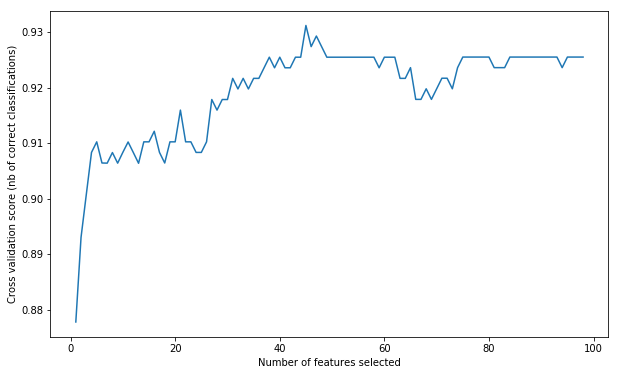

In [155]:
rfecv = RFECV(estimator=LogisticRegression(solver='lbfgs',max_iter=2000), step=1, cv=7, scoring='accuracy')
rfecv.fit(train_X, train_y)
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Here I get the major features contributing to the price of fountain pen.

In [156]:
selected_features = list(X.columns[rfecv.support_])
print(len(selected_features))
print(selected_features)

45
['Diameter_Grip', 'Max_Ink_Capacity', 'Color_Black', 'Color_Clear', 'Color_Copper', 'Color_Green', 'Color_Ivory', 'Color_Pink', 'Color_Purple', 'Color_Red', 'Demonstrator_No', 'Demonstrator_Yes', 'Body_Material_Aluminum', 'Body_Material_Carbon fiber, Metal', 'Body_Material_Copper', 'Body_Material_Ebonite', 'Body_Material_Ebonite, Resin', 'Body_Material_Metal', 'Body_Material_Resin', 'Body_Material_Stainless Steel', 'Cap_Type_Hook Safe Lock', 'Cap_Type_Magnetic cap', 'Cap_Type_Snap-cap', 'Filling_Mechanism_Converter', 'Filling_Mechanism_Eyedropper', 'Filling_Mechanism_Power Filler', 'Filling_Mechanism_Vacuum', 'Grip_Material_Aluminum', 'Grip_Material_Lacquered metal', 'Grip_Material_Metal', 'Grip_Material_Stainless steel', 'Grip_Material_Wood', 'Nib_Color_Black', 'Nib_Color_Bronze', 'Nib_Color_Gold', 'Nib_Color_Rose Gold', 'Nib_Color_Ruthenium', 'Nib_Color_Silver', 'Nib_Material_14kt Gold', 'Nib_Material_18kt Gold', 'Nib_Material_23kt Palladium', 'Nib_Material_Steel', 'Nib_Material_T

In [157]:
train_X = train_X[selected_features]
test_X = test_X[selected_features]

### *Model Validation Choice 1*: train-test validation

/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy is: 0.9312977099236641
The log loss is: 0.20542402255111428


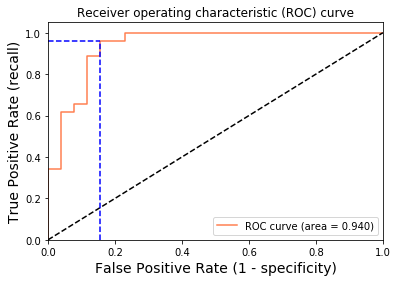

In [165]:
logistic_reg = LogisticRegression()
logistic_reg.fit(train_X, train_y)
pred_y = logistic_reg.predict(test_X)
pred_proba_y = logistic_reg.predict_proba(test_X)[:, 1]
[fpr, tpr, thr] = roc_curve(test_y, pred_proba_y)
print("The accuracy is: {}".format(logistic_reg.score(test_X, test_y)))
print("The log loss is: {}".format(log_loss(test_y, pred_proba_y)))
idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

### *Model Validation Choice 2*: GridSearchCV evaluating using multiple scorers, RepeatedStratifiedKFold and pipeline 

Credit to [Titanic: logistic regression with python](https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python)

In [ ]:
## build model
C = np.arange(1e-05, 5.5, 0.1)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg = LogisticRegression()
## set pre-processing estimators
std_scale = StandardScaler(with_mean=False, with_std=False)
## use the Repeated Stratified K Fold Cross Validation method
n_folds=5
n_repeats=5
rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=2)
## create pipeline and defining the gridsearch
log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')
log_clf.fit(train_X, train_y)
results = log_clf.cv_results_

In [174]:
print(log_clf.best_estimator_)
print(log_clf.best_score_)
print(log_clf.score(test_X,test_y))
print(classification_report(test_y, log_clf.predict(test_X)))

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=False, with_std=False)), ('clf', LogisticRegression(C=1.6000100000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])
0.9274809160305344
0.9312977099236641
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        26
           1       0.94      0.97      0.96       105

   micro avg       0.93      0.93      0.93       131
   macro avg       0.91      0.87      0.89       131
weighted avg       0.93      0.93      0.93       131



/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


## *Model B* Summary

In this model, I just interested in the outcome features, which I think is important to concern. So more weighting should be put into the model selection part.

As we can see, when it comes to model tuning part. The accuracy scores of both sub-model seems not high enough for this unbalanced dataset. So the model predicting is not so plausible. But the model could also be use for a side concern for the price setting.

# Summary

This two model both could have lots of potential to be used in different occasions.

## Perspective

Model A

- Numeric result predicting with more balanced dataset
- Text feature engineering to check the text is intuiting or not
- Estimate an unknown product price
- Filter choice with a limited budget

Model B

- Factor out the important features for any product
- Filter choices for customer purchase
- Help industry to product design

## Further work

- A deeper exploration of unbalanced data
- Building model from customer perspective from customer ranking or other feedback